# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=100,
                       initial_x = [0.2, 0.8], 
                       file_name="Turing_sequential_samples",  
                       dialog=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


Burn in step: 2000
eps --->0.029159332038321606
L   --->0.008414645608255241
 


MCHMC (tuning):  21%|███████▎                           |  ETA: 0:00:00

Burn in step: 4000
eps --->0.02819457693232626
L   --->0.009419608303731817
 
Burn in step: 6000
eps --->0.026549153933276254
L   --->0.008963765979078123
 


Burn in step: 8000
eps --->0.028945027261194876
L   --->0.008943953526841488
 
Burn in step: 10000
eps --->0.029965172951672392
L   --->0.004164614060396824
 


[ Info: eps: 0.029965172951672392
[ Info: L: 0.004164614060396824
[ Info: nu: 20.148672821561856
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:05

100000-element Vector{Any}:
 [0.20979422292001765, 0.8931919490605644, 0.029965172951672392, -0.07366055163566898, 16.20465155985121]
 [0.21289874874376305, 0.9119007857312389, 0.03004998599776635, -0.7715280346552973, 15.825515917626994]
 [0.21212186447246378, 0.882423978934932, 0.02987779063766322, 1.359016922203585, 16.28126368447125]
 [0.2086276041169527, 0.8684478495132504, 0.03005763088308572, -0.07984245936861711, 16.250170886585583]
 [0.20478251129845126, 0.8618511661387697, 0.030248982203696193, -0.236753279507667, 16.129639790140303]
 [0.20096743899428113, 0.8690189585742709, 0.030372782636995495, 0.00860823109163178, 16.152652767187142]
 [0.1998946816908404, 0.8982305129898587, 0.03055857890319009, 0.07809699386148239, 16.186235079071242]
 [0.19695036474555286, 0.8780627167154975, 0.030741016059280042, -0.06206107385942872, 16.171267428425864]
 [0.19920151242832965, 0.8528379334613452, 0.03085436721736842, -0.6958581564613304, 15.83873276972628]
 [0.20147942336288474, 0.8781

In [9]:
std(samples_mchmc)[1:end-2]

3-element Vector{Float64}:
 0.04452491001343549
 0.04373727414448151
 0.004602214452627083

In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

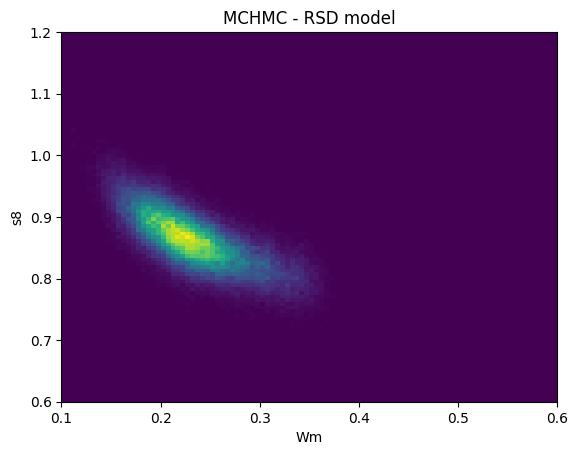

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

##  AbstractMCMC

In [12]:
spl = MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2))
samples = sample(stat_model, spl, 10_000; dialog=true, progress=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  18%|██████▌                            |  ETA: 0:00:00

Burn in step: 2000
eps --->0.03629392169881751
L   --->0.010463989892454286
 


MCHMC (tuning):  38%|█████████████▍                     |  ETA: 0:00:00

Burn in step: 4000
eps --->0.025880184152791193
L   --->0.009144594211266817
 


MCHMC (tuning):  59%|████████████████████▊              |  ETA: 0:00:00

Burn in step: 6000
eps --->0.029712276819895227
L   --->0.010721927022401804
 


MCHMC (tuning):  80%|███████████████████████████▉       |  ETA: 0:00:00

Burn in step: 8000
eps --->0.024630930521068288
L   --->0.008184879101775424
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00

Burn in step: 10000
eps --->0.028584990478263135
L   --->0.00483434020604687
 


[ Info: eps: 0.028584990478263135
[ Info: L: 0.00483434020604687
[ Info: nu: 23.228449227841327
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×5×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.66 seconds
Compute duration  = 1.66 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2231    0.0336     0.0003    0.0032   28.7337    1.0053      ⋯
          σ8    0.8693    0.0399     0.0004    0.0027   60.9667    1.0008      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1645    0.1975    0.2202    0.2504    0.2839
          σ8    0.7949    0.8412    0.8678    0.8957    0.9513


In [13]:
new_samples = sample(stat_model, spl, 1_000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run


Chains MCMC chain (1000×5×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.3 seconds
Compute duration  = 0.3 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2176    0.0135     0.0004    0.0023    3.9236    1.4815      ⋯
          σ8    0.8678    0.0332     0.0010    0.0035   40.8148    1.0543      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1954    0.2046    0.2204    0.2281    0.2425
          σ8    0.8010    0.8465    0.8689    0.8917    0.9298


## Ensemble AbstractMCMC

In [14]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples = sample(stat_model, spl, 1000; burn_in=100, dialog=true)

LoadError: MethodError: no method matching iterate(::MicroCanonicalHMC.EnsembleState{Float64})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


In [15]:
new_samples = sample(stat_model, spl, 1000; burn_in=100, 
                     resume_from=samples)

[ Info: Starting from previous run


Chains MCMC chain (1000×5×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.3 seconds
Compute duration  = 0.3 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2186    0.0297     0.0009    0.0052    5.2286    1.1507      ⋯
          σ8    0.8742    0.0346     0.0011    0.0040   16.0303    1.0534      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1838    0.1945    0.2122    0.2312    0.2842
          σ8    0.8037    0.8503    0.8762    0.8984    0.9396


## Parallelization

In [23]:
samples = sample(
    stat_model, MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2)), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.


LoadError: TaskFailedException

[91m    nested task error: [39mUndefKeywordError: keyword argument `progress` not assigned
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:222[24m[39m[90m [inlined][39m
     [2] [0m[1m(::MicroCanonicalHMC.var"#1055#threadsfor_fun#196"{MicroCanonicalHMC.var"#1055#threadsfor_fun#185#197"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMicroCanonicalHMC[39m [90m[4mthreadingconstructs.jl:139[24m[39m
     [3] [0m[1m#1055#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#1055#threadsfor_fun#196"{MicroCanonicalHMC.var"#1055#threadsfor_fun#185#197"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [24]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

LoadError: MethodError: no method matching MCHMC(; varE_wanted::Float64)

[0mClosest candidates are:
[0m  MCHMC([91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/ensemble/[39m[90m[4msampler.jl:26[24m[39m
[0m  MCHMC([91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4msampler.jl:53[24m[39m
[0m  MCHMC([91m::Any[39m, [91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/ensemble/[39m[90m[4msampler.jl:8[24m[39m


## NUTS

In [18]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [19]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.0 seconds
Compute duration  = 11.0 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2376    0.0693     0.0007    0.0015   1479.6564    1.0001    ⋯
          σ8    0.8661    0.0629     0.0006    0.0013   2155.7837    1.0003    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [20]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.14131   0.951565  14.9575   7.0  1.0  …  3.0  0.0  0.0509846  0.0509846
 0.131044  0.946093  14.2886   7.0  1.0     2.0  0.0  0.0509846  0.0509846
 0.131732  0.934174  14.1311   3.0  1.0     2.0  0.0  0.0509846  0.0509846
 0.146072  0.940361  15.1291  15.0  1.0     4.0  0.0  0.0509846  0.0509846
 0.211862  0.861762  16.2297  27.0  1.0     4.0  0.0  0.0509846  0.0509846
 0.247328  0.849626  16.2458  23.0  1.0  …  4.0  0.0  0.0509846  0.0509846
 0.257021  0.842653  16.1831  15.0  1.0     3.0  0.0  0.0509846  0.0509846
 0.180773  0.901615  16.0187  23.0  1.0     4.0  0.0  0.0509846  0.0509846
 0.246707  0.82305   15.9929  19.0  1.0 

In [21]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

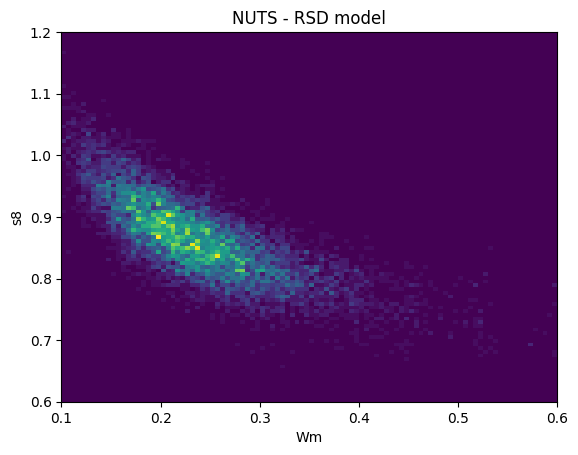

In [22]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");